In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers # Framework for neural nets creating
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.applications import Xception, VGG19, ResNet50, MobileNet,InceptionResNetV2
from keras.models import Model


import os, shutil # filesystem operations 
from os import listdir
from os.path import isfile, join

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix



import random
#import tensorflow_addons as tfa
#from keras import optimizers
#from keras.utils import image_dataset_from_directory
#%matplotlib inline
#from pathlib import Path

In [2]:
# # GPU checking
# device_names = tf.test.gpu_device_name()
# device_names

# Data preparation****

In [3]:
batch_size = 32
#image_size = 256
target_size = (224,224)
input_shape = (224, 224, 3)

In [4]:
#Fetching train data and validation data and processing the data
train_datagen = ImageDataGenerator(rescale = 1.00 / 255.0)
val_datagen = ImageDataGenerator(rescale = 1.00 / 255.0)
test_datagen = ImageDataGenerator(rescale = 1.00 / 255.0)

train_generator = train_datagen.flow_from_directory(
    'Train_10_2/',
    target_size = target_size,
    batch_size = batch_size

)

validation_generator = val_datagen.flow_from_directory(
    'Validation_10_2/',
    target_size = target_size,
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    'Test_10_2/',
    target_size = target_size,
    batch_size = batch_size
)

Found 1342 images belonging to 10 classes.
Found 162 images belonging to 10 classes.
Found 162 images belonging to 10 classes.


In [5]:
classes_list = ['Bamboo', 'Basale', 'Beans', 'Betel', 'Betel_Nut', 'Bhrami', 'Bringaraja', 'camphor',
                'Caricature', 'Castor']

In [6]:
model_xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
model_xception.trainable = False
model_vgg19.trainable = False
model_mobilenet.trainable = False

# VGG19

In [7]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# add new classifier layers
flat1 = model_vgg19.layers[-1].output
# flat1 = Flat(flat1)
flat1 = GlobalAveragePooling2D()(flat1)
class1 = layers.Dense(1024, activation='relu')(flat1)
class1 = layers.Dense(512, activation='relu')(class1)
class1 = layers.Dense(256, activation='relu')(class1)
# class1 = layers.Dense(128, activation='relu')(class1)
# class1 = layers.Dense(64, activation='relu')(class1)
output = layers.Dense(10, activation='softmax')(class1)
# define new model
model = Model(inputs=model_vgg19.inputs, outputs=output)
model.compile(
  loss = "categorical_crossentropy",
  optimizer="adam",
  metrics = ["acc"]
)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [11]:
#Training the model with train data and judging this training with validation data
history1 = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs = 2,
    validation_data = validation_generator, 
    callbacks=[es],
    verbose=1)

Epoch 1/2
42/42 [==============================] - 424s 10s/step - loss: 1.7213 - acc: 0.4121 - val_loss: 1.3213 - val_acc: 0.5679
Epoch 2/2
42/42 [==============================] - 468s 11s/step - loss: 0.9030 - acc: 0.7057 - val_loss: 0.6356 - val_acc: 0.8148


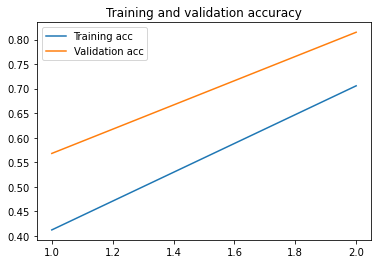

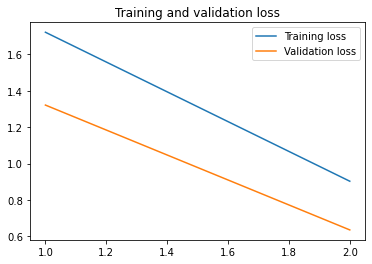

In [12]:
# Plot the train results
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
test_preds = model.predict(test_generator)
test_pred_labels = np.argmax(test_preds, axis=1)
cm = confusion_matrix(test_generator.classes, test_pred_labels)
cm

6/6 [==============================] - 50s 8s/step


array([[2, 4, 2, 2, 3, 6, 1, 2, 4, 0],
       [1, 1, 2, 2, 1, 2, 0, 1, 4, 0],
       [4, 0, 1, 0, 1, 2, 0, 0, 1, 0],
       [5, 2, 2, 7, 2, 5, 0, 1, 2, 0],
       [2, 2, 2, 4, 2, 1, 0, 0, 1, 0],
       [4, 3, 3, 5, 2, 2, 0, 3, 3, 0],
       [2, 0, 0, 1, 3, 1, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 3, 0, 0, 1, 0],
       [4, 3, 0, 6, 2, 4, 1, 2, 6, 0],
       [1, 0, 0, 0, 2, 2, 0, 0, 1, 0]], dtype=int64)

In [14]:
def plot_confusion_matrix(cm,
                      classes, 
                      normalized=False, 
                      title=None, 
                      cmap=plt.cm.Blues,
                      size=(16,12)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

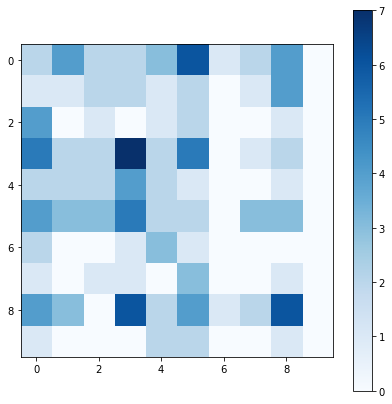

In [15]:
plot_confusion_matrix(cm,
                      classes_list, 
                      normalized=True, 
                      title="Model Performance", 
                      cmap=plt.cm.Blues,
                      size=(7, 7))

In [16]:
result = model.evaluate(test_generator)

6/6 [==============================] - 45s 7s/step - loss: 0.4704 - acc: 0.8765


In [26]:
# import os
# model_version=max([int(i) for i in os.listdir(r"C:\Users\Aalap.LIPI\OneDrive\Desktop\Hackathon\Final Project\models") + [0]])+1
# model.save(fr"C:\Users\Aalap.LIPI\OneDrive\Desktop\Hackathon\Final Project\models/{model_version}")

ValueError: invalid literal for int() with base 10: 'Plant_Identification_model.h5'

In [22]:
# model.save(r"C:\Users\Aalap.LIPI\OneDrive\Desktop\Hackathon\Final Project\models\Plant_Identification_model.h5")

In [43]:
# Load your pre-trained model (replace 'model_path' with your model's file path)
model_path = r"C:\Users\Aalap.LIPI\OneDrive\Desktop\Hackathon\Final Project\models\Plant_Identification_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

In [44]:
# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Adjust target size as per your model's input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Replace with your model's preprocess_input function
    return img_array

In [45]:
# Define a function to make predictions
def predict_image(model, image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    return predictions

In [56]:
from tensorflow.keras.preprocessing import image
# Test the model on a new, unseen image
image_path = r"C:\Users\Aalap.LIPI\OneDrive\Desktop\Hackathon\Final Project\betel2.jpg"  # Replace with the path to your unseen image
 # Replace with the path to your unseen image
predictions = predict_image(loaded_model, image_path)# Decode predictions (assuming you used one-hot encoding for class labels)
class_labels = ['Bamboo', 'Basale', 'Beans', 'Betel', 'Betel_Nut', 'Bhrami', 'Bringaraja', 'camphor', 'Caricature', 'Castor']  # Replace with your class labels
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

1/1 [==============================] - 0s 173ms/step


In [57]:
# Print the predicted class label and confidence score
print(f"Predicted class: {predicted_class_label}")
print(f"Confidence score: {predictions[0][predicted_class_index]}")

Predicted class: Betel
Confidence score: 0.9800856709480286
